![bse_logo_textminingcourse](https://bse.eu/sites/default/files/bse_logo_small.png)

# Introduction to Text Mining

### Homework 1

### Group Members: Deepak Malik, Noemi Lucchi, Tirdod Behbehani

### Text Analysis and Difference-in-Differences

In [3]:
# Import the necessary packages 
import re 
import spacy
import nltk
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from linearmodels.panel import PanelOLS
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/noemilucchi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/noemilucchi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
# Import the 4 datasets - Barcelona before and after the treatment, Madrid before and after the treatment 
df1 = pd.read_csv('/Users/noemilucchi/Desktop/hw1_Deepak,Noemi,Tirdod/barcelona_march3_march6.csv')
df2 = pd.read_csv('/Users/noemilucchi/Desktop/hw1_Deepak,Noemi,Tirdod/barcelona_feb24_feb27.csv')
df3 = pd.read_csv('/Users/noemilucchi/Desktop/hw1_Deepak,Noemi,Tirdod/madrid_march3_march6.csv')
df4 = pd.read_csv('/Users/noemilucchi/Desktop/hw1_Deepak,Noemi,Tirdod/madrid_feb24_feb27.csv')

## Create the dummy variables:
- dummy Time that is equal to 1 if data refers to post-treatment period and and equal to 0 if data refers to before the treatment period 
- dummy Treatment that is equal to 1 if the hotel is in Barcelona and equal to 0 if the hotel is in Madrid

In [5]:
df1['Treated'] = 1
df1['Time'] = 1
df2['Treated'] = 1
df2['Time'] = 0
df3['Treated'] = 0
df3['Time'] = 1
df4['Treated'] = 0
df4['Time'] = 0

## Merge the 4 datasets into a unique dataset and create the interaction between time and treatment, whose coefficient will be the causal effect of interest 

In [6]:
df = pd.concat([df1, df2, df3, df4], ignore_index=True)

In [7]:
df['Treated_Time'] = df['Treated'] * df['Time']

In [8]:
# Drop the first row
df = df.drop(index=0)

## Clean the price column: transform into a string to apply the Regex function to remove everything that is not a number, and then convert to numeric 

In [9]:
df['Price'] = df['Price'].astype(str) 
df['Price'] = df['Price'].apply(lambda x: re.sub(r'[^\d]', '', x) if pd.notnull(x) else x)  
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

## Convert the Rating column to numeric and clean the Number of Ratings column (keep only the number of ratings and convert to numeric)

In [10]:
df['Number of Ratings'] = df['Number of Ratings'].apply(lambda x: re.sub(r'[^\d]', '', x) if pd.notnull(x) else x)  
df['Number of Ratings'] = pd.to_numeric(df['Number of Ratings'], errors='coerce')
df.rename(columns={'Number of Ratings': 'Number_Ratings'}, inplace=True)

In [11]:
# First replace the coma with the period in order to properly convert to numeric - otherwise we would get only NA for the whole column 
df['Rating'] = df['Rating'].astype(str).str.replace(',', '.')
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')

## Data Analysis 

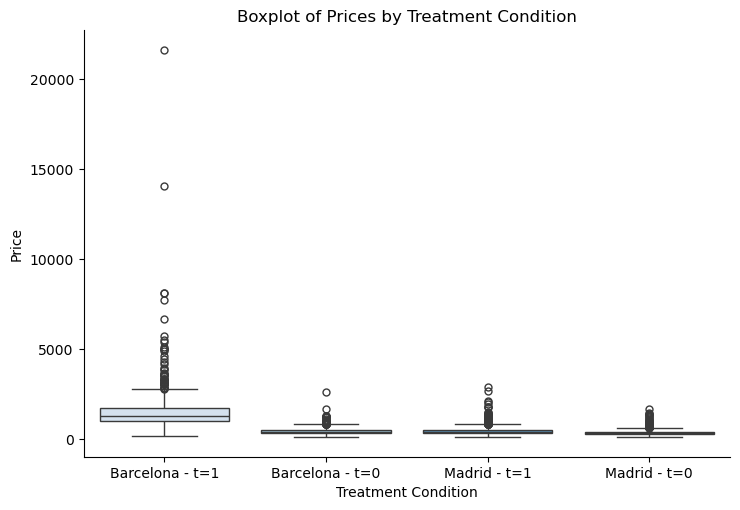

In [12]:
# Boxplot to visualize the price distribution across different periods and cities 
df['Treatment_condition'] = df['Time'] * 2 + df['Treated']
mapping = {0: 'Madrid - t=0', 1: 'Barcelona - t=0', 2: 'Madrid - t=1', 3: 'Barcelona - t=1'}
df['Treatment_condition'] = df['Treatment_condition'].map(mapping)
df = df.dropna(subset=['Price', 'Treatment_condition'])
sns.catplot(
    data=df, 
    x='Treatment_condition', 
    y='Price', 
    kind='box', 
    hue='Treatment_condition',
    palette='Blues', 
    height=5, 
    aspect=1.5
)
plt.xlabel('Treatment Condition')
plt.ylabel('Price')
plt.title('Boxplot of Prices by Treatment Condition')
plt.show()

In [13]:
# Compute the conditional means 
df.groupby(['Treated', 'Time'])['Price'].mean()

Treated  Time
0        0        370.422723
         1        472.403125
1        0        458.086368
         1       1521.254524
Name: Price, dtype: float64

From the boxplot and the conditional means we can already notice that:
- the common support assumption holds, given that before the event the average prices were close in Barcelona and Madrid;
- the event has a great impact on hotel prices, given that the average price dramatically jumps in Barcelona during the event.

Additionally, we observe that in Barcelona during the event, a few hotels exhibit extremely high prices. We will remove these outliers and compute the causal effect for both the complete dataset and the cleaned dataset (without outliers).
Such exceptionally high prices are unlikely to be solely justified by the event and may instead be driven by random factors. To ensure more generalizable results, removing these outliers could lead to more robust findings.

In [14]:
# Identify outliers
Q1 = df['Price'].quantile(0.10)
Q3 = df['Price'].quantile(0.90)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Define a new dataset without outliers 
df_cleaned = df[(df['Price'] >= lower_bound) & (df['Price'] <= upper_bound)]

# Verify hom many rows have been removed 
print(f"Original number of rows: {len(df)}, Rows after removing outliers: {len(df_cleaned)}")

Original number of rows: 3727, Rows after removing outliers: 3689


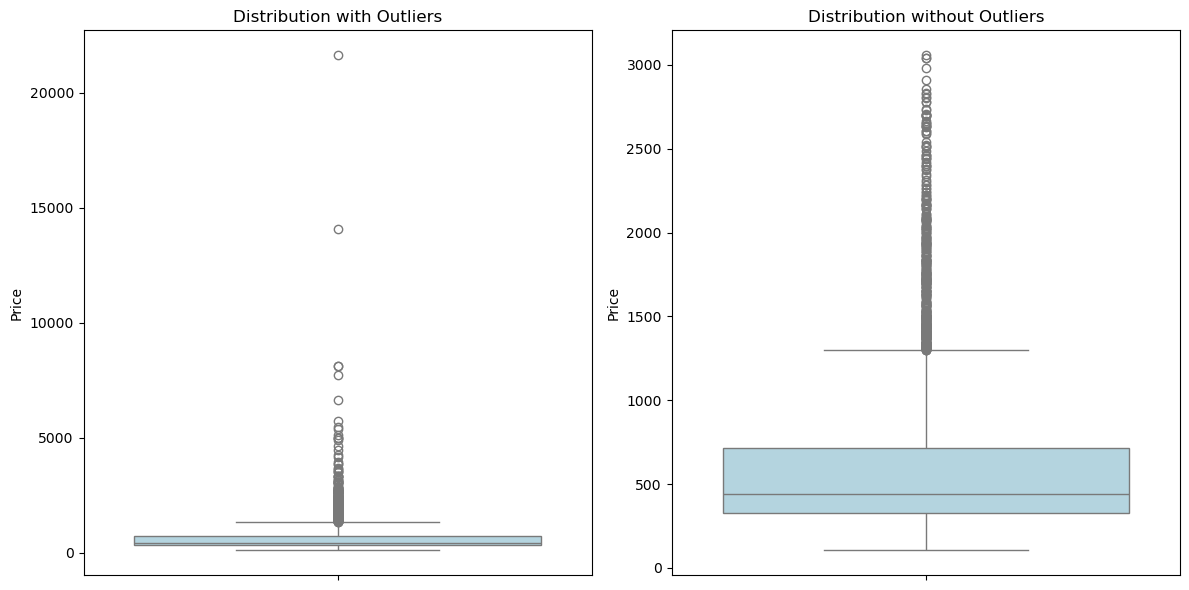

In [15]:
# Compare prices before and after removing outliers 
plt.figure(figsize=(12, 6))

# Before removing 
plt.subplot(1, 2, 1)
sns.boxplot(data=df, y='Price', color='lightblue') 
plt.title('Distribution with Outliers')

# After removing
plt.subplot(1, 2, 2)
sns.boxplot(data=df_cleaned, y='Price', color='lightblue')  
plt.title('Distribution without Outliers')
plt.tight_layout()
plt.show()

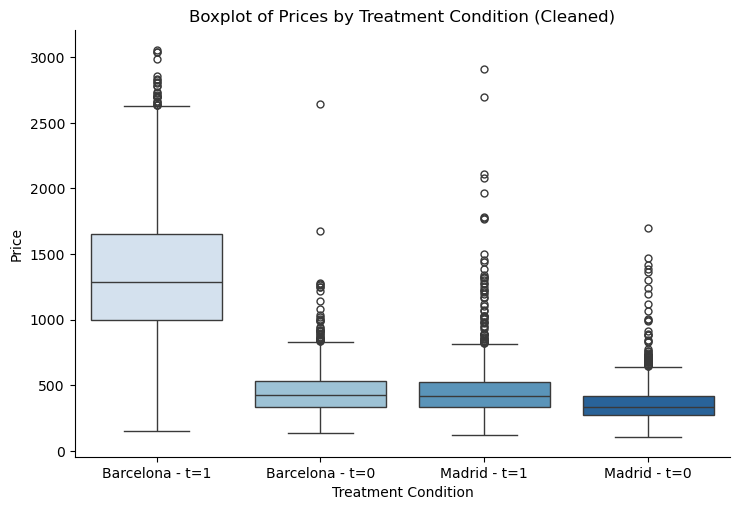

In [16]:
# Boxplot to visualize the price distribution across different periods and cities - after removing outliers 
sns.catplot(
    data=df_cleaned, 
    x='Treatment_condition', 
    y='Price', 
    kind='box', 
    hue='Treatment_condition',
    palette='Blues', 
    height=5, 
    aspect=1.5
)
plt.xlabel('Treatment Condition')
plt.ylabel('Price')
plt.title('Boxplot of Prices by Treatment Condition (Cleaned)')
plt.show()

In [17]:
# Compute the conditional means after removing outliers 
df_cleaned.groupby(['Treated', 'Time'])['Price'].mean()

Treated  Time
0        0        370.422723
         1        472.403125
1        0        458.086368
         1       1349.140329
Name: Price, dtype: float64

After removing the outliers the average hotel price in Barcelona during the event is approximatively 140€ lower. 

## Check whether there are systematic differences between Barcelona and Madrid in terms of Number of Ratings and Rating

In [18]:
df[df['Treated'] == 1]['Number_Ratings'].mean()

1366.8256672345258

In [19]:
df[df['Treated'] == 0]['Number_Ratings'].mean()

1112.9978969505783

In [20]:
df[df['Treated'] == 1]['Rating'].mean()

8.168033352501437

In [21]:
df[df['Treated'] == 0]['Rating'].mean()

7.930324123273114

We can observe that:
- in Barcelona hotels have on average higher ratings (although the difference being extremely small)
- in Barcelona hotels have on average an higher number of reviews 

## Part 2: Text Analysis

Before we run our regressions, we will clean and proprocess our hotel descriptions for text analysis. 

A general overview of our preprocessing is:

1. Input custom stopwords, so that we can remove extraneous text that doesn't add any value to our analysis
2. Convert text to lowercase
3. Split text into individual words (tokenization)
4. Remove the custom stopwords that we previously inputted
5. Apply stemming (revert words to root form)
6. Export our cleaned text into a new "cleaned" column

In [22]:
# Set tqdm 
tqdm.pandas()

# Initialize the stemmer
ps = PorterStemmer()

# Define the list with the personalized stop words 
custom_stopwords = {'el', 'del', 'con', 'se', 'en', 'de', 'la', 'y', 'las', 'barcelona', 
                    'está', 'por', 'un', 'una', 'este', 'como', 'que', 'lo', 'o', 'su', 
                    'sus', 'mas', 'además', 'están', 'españa', 'madrid'}
STOP_WORDS = set(stopwords.words('spanish'))  # Set spanish stopwords
STOP_WORDS.update(custom_stopwords)

# Function to pre-process
def text_processing(text):
    if not isinstance(text, str):  # Check whether the value is a string
        return ""  # Return an empy string for NA

    # Convert to lowercase
    text = text.lower()
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stop words 
    tokens = [token for token in tokens if token not in STOP_WORDS and token.isalnum()]
    
    # Apply stemming
    stemmed_tokens = [ps.stem(token) for token in tokens]
    
    return " ".join(stemmed_tokens)

# Apply the function to the Description column 
df['Description'] = df['Description'].astype(str)
df['Description_cleaned'] = df['Description'].progress_apply(text_processing)
print(df[['Description', 'Description_cleaned']].head())

100%|██████████| 3727/3727 [00:05<00:00, 651.21it/s]

                                         Description  \
1  Isabella's House se encuentra a 2,9 km de Pase...   
2  El Sonder Casa Luz se encuentra en Barcelona y...   
3  The Social Hub Barcelona Poblenou está en Barc...   
4  H Regas Adults Only, que está a 6 min a pie de...   
5  El TWO Hotel Barcelona by Axel está situado en...   

                                 Description_cleaned  
1  isabella hous encuentra km paseo gracia ofrec ...  
2  sonder casa luz encuentra ofrec terraza desayu...  
3  the social hub poblen 16 min pie platja llevan...  
4  h rega adult onli 6 min pie paseo gracia 1 km ...  
5  two hotel by axel situado pleno barrio gay 2 k...  


## Word cloud of the descriptions before processing 

### Barcelona (Treatment City)

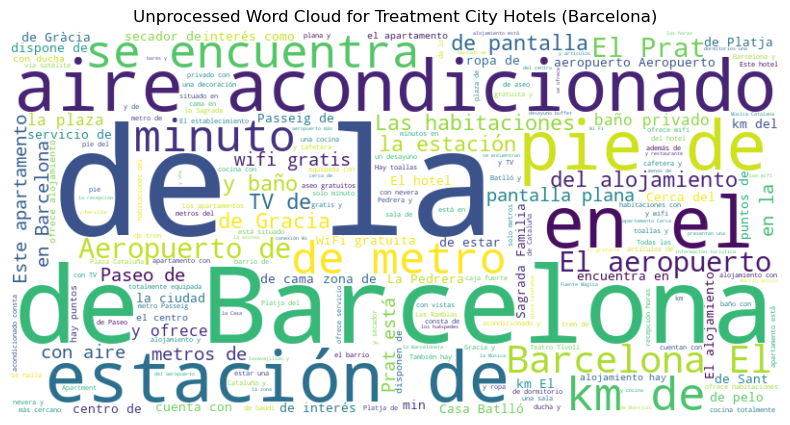

In [23]:
# Combine values from the column into a unique string
text = " ".join(df['Description'])

# Generate the word cloud only for hotels where Treated = 1 (Barcelona)
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white'
).generate(" ".join(df.loc[df['Treated'] == 1, 'Description']))

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.title("Unprocessed Word Cloud for Treatment City Hotels (Barcelona)")
plt.show()

### Madrid (Control City)

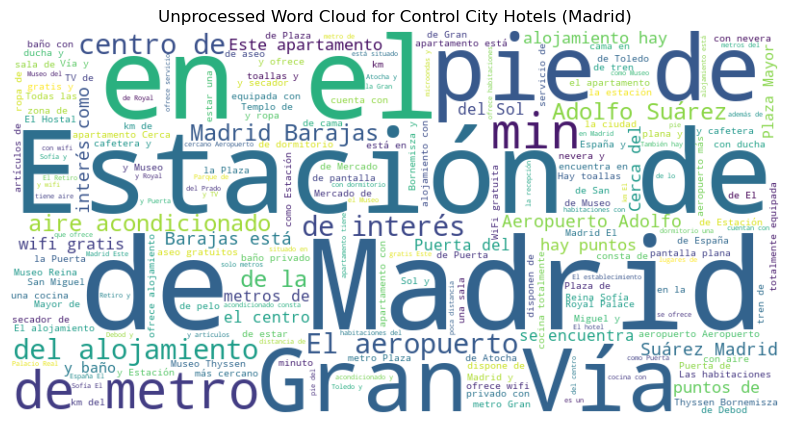

In [24]:
# Combine values from the column into a unique string
text = " ".join(df['Description'])

# Generate the word cloud only for hotels where Treated = 1 (Barcelona)
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white'
).generate(" ".join(df.loc[df['Treated'] == 0, 'Description']))

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.title("Unprocessed Word Cloud for Control City Hotels (Madrid)")
plt.show()

## Word cloud of the descriptions after processing 

### Barcelona (Treatment City)

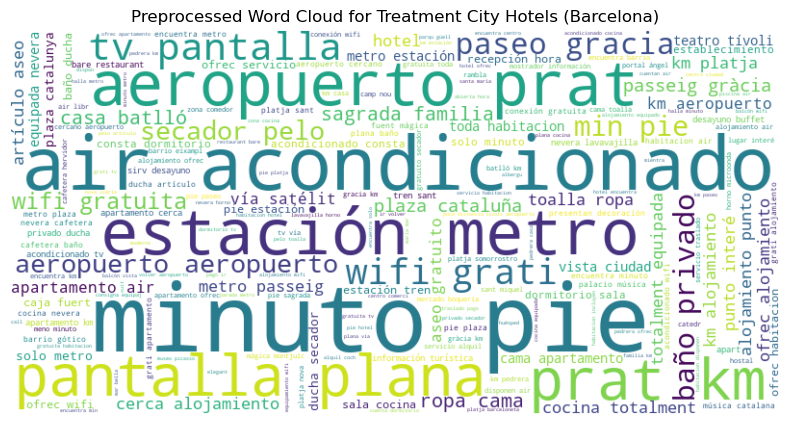

In [25]:
# Combine values from the column into a unique string
text = " ".join(df['Description_cleaned'])

# Generate the word cloud only for hotels where Treated = 1 (Barcelona)
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white'
).generate(" ".join(df.loc[df['Treated'] == 1, 'Description_cleaned']))

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.title("Preprocessed Word Cloud for Treatment City Hotels (Barcelona)")
plt.show()

### Madrid (Control city)

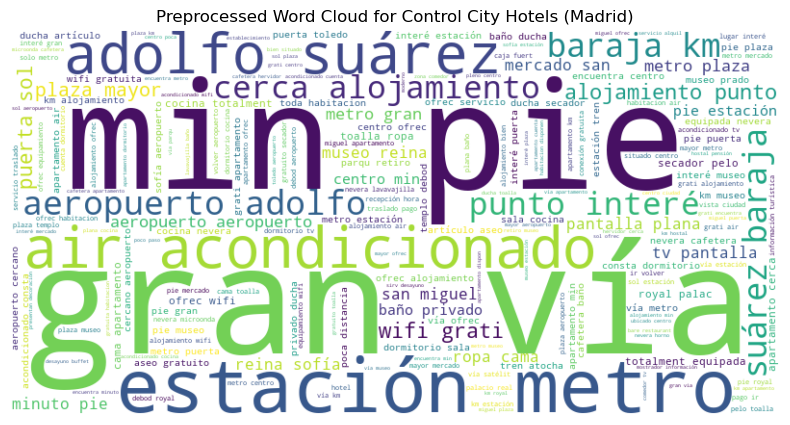

In [26]:
# Combine values from the column into a unique string
text = " ".join(df['Description_cleaned'])

# Generate the word cloud only for hotels where Treated = 0 (Madrid)
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white'
).generate(" ".join(df.loc[df['Treated'] == 0, 'Description_cleaned']))

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.title("Preprocessed Word Cloud for Control City Hotels (Madrid)")
plt.show()

In [27]:
# Create Document-Term Matrix using CountVectorizer
pd.set_option('display.max_columns', None)
vectorizer = CountVectorizer(ngram_range = (1,2), min_df=0.05, max_df=0.99)
X = vectorizer.fit_transform(df['Description_cleaned'])

# Convert DTM to DataFrame
dtm_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
display(dtm_df)
dtm_df.shape

,10,10 minuto,100,100 metro,11,11 min,12,12 km,13,13 km,14,14 km,15,15 km,15 minuto,18,20,20 minuto,200,200 metro,24,24 hora,300,300 metro,400,400 metro,500,500 metro,600,600 metro,700,700 metro,800,800 metro,900,900 metro,abierta,acceso,acondicionado,acondicionado consta,acondicionado tv,acondicionado wifi,adolfo,adolfo suárez,aeropuerto,aeropuerto adolfo,aeropuerto aeropuerto,aeropuerto cercano,aeropuerto prat,air,air acondicionado,alberga,alojamiento,alojamiento air,alojamiento bien,alojamiento ofrec,alojamiento punto,alojamiento wifi,alquil,amplia,aparcamiento,apart,apartamento,apartamento air,apartamento cerca,apartamento km,apartamento ofrec,artículo,artículo aseo,aseo,aseo gratuito,atocha,azotea,balcón,bar,baraja,baraja 12,baraja 13,baraja 14,barceloneta,bare,bare restaurant,barrio,batlló,bañera,baño,baño ducha,baño privado,bien,buffet,cada,cafetera,cafetera baño,cafetera hervidor,cafetería,caja,caja fuert,calefacción,call,cama,cama apartamento,cama toalla,canal,casa,casa batlló,catalana,catalunya,cataluña,catedr,centro,centro ciudad,centro min,centro ofrec,cerca,cerca alojamiento,cercano,cercano aeropuerto,ciudad,coch,cocina,cocina nevera,cocina totalment,comedor,compartido,conexión,conexión gratuita,conexión wifi,consta,consta dormitorio,cuenta,cuenta dormitorio,cuentan,debod,decoración,desayuno,desayuno buffet,dispon,disponen,distancia,dormitorio,dormitorio cocina,dormitorio sala,dormitorio tv,ducha,ducha artículo,ducha secador,ducha toalla,edificio,elegant,encuentra,encuentra centro,encuentran,equipada,equipada nevera,equipado,equipamiento,equipamiento wifi,escritorio,establecimiento,estación,estación metro,estación tren,familia,famosa,fogon,fuent,fuert,gaudí,gracia,gran,gran vía,grati,grati air,grati alojamiento,grati apartamento,gratuita,gratuita toda,gratuito,gratuito secador,gràcia,habitacion,habitacion air,halla,hervidor,hora,horno,hostal,hotel,huésped,in,incluy,incluyen,información,información turística,interé,interé estación,interé museo,interé puerta,ir,ir volver,junto,km,km aeropuerto,km alojamiento,km estación,km museo,km platja,lavadora,lavavajilla,libr,lugar,lugar interé,mayor,meno,mercado,mercado san,metro,metro centro,metro estación,metro gran,metro mercado,metro passeig,metro plaza,metro puerta,microonda,miguel,miguel apartamento,min,min pie,minibar,minuto,minuto pie,moderna,moderno,mostrador,mostrador información,museo,museo prado,museo reina,música,nevera,nevera cafetera,nevera horno,nevera lavavajilla,nevera microonda,numeroso,of,of aeropuerto,ofrec,ofrec alojamiento,ofrec habitacion,ofrec servicio,ofrec wifi,ofrecen,pago,pago ir,palac,palac of,palacio,palacio real,pantalla,pantalla plana,parada,parqu,parqu retiro,paseo,paseo gracia,paso,passeig,passeig gràcia,pedrera,pelo,pelo toalla,person,pie,pie estación,pie gran,pie mercado,pie museo,pie plaza,pie puerta,piscina,plana,plana baño,platja,playa,plaza,plaza catalunya,plaza cataluña,plaza mayor,pleno,poca,poca distancia,poco,prado,prat,presentan,presentan decoración,privado,privado ducha,pued,pueden,puerta,puerta sol,puerta toledo,punto,punto interé,queda,rambla,real,recepción,recepción 24,reina,reina sofía,restaurant,retiro,ropa,ropa cama,royal,royal palac,sagrada,sagrada familia,sala,sala cocina,salón,san,san miguel,sant,satélit,secador,secador pelo,servicio,servicio alquil,servicio traslado,sirv,sirv desayuno,situado,situado centro,sofía,sofía aeropuerto,sol,solo,suelo,suplemento,suárez,suárez baraja,teatro,teatro tívoli,templo,templo debod,terraza,tienda,toalla,toalla ropa,toda,toda habitacion,toledo,totalment,totalment equipada,traslado,traslado pago,tren,tren atocha,turística,tv,tv pantalla,tv vía,tívoli,ubicación,ubicado,unidad,vario,vista,vista ciudad,volver,volver aeropuerto,vía,vía ofrec,vía satélit,wifi,wifi grati,wifi gratuita,zona,zona comedor
0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,1,0,1,1,1,0,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,1,0,1,0,0,0

(3727, 384)

In [28]:
# Calculate the sum of occurrences for each word across all documents
word_sums = dtm_df.sum(axis=0)

# Sort the words by their summed occurrences in descending order
sorted_words = word_sums.sort_values(ascending=False)

# Get the top 10 most common words
top_10_words = sorted_words.head(10)
print(top_10_words)

metro          6274
alojamiento    5365
km             5301
aeropuerto     5030
pie            4985
apartamento    4544
ofrec          4433
estación       3728
plaza          3314
wifi           3073
dtype: int64


We briefly explain the reasons for setting these specific parameter values in **(ngram_range = (1,2), min_df=0.05, max_df=0.99)**:

- **ngram_range = (1,2):** This allows us to include both single words (unigrams) and two-word phrases (bigrams) in the Document-Term Matrix.

- **min_df=0.05** This ensures that extremely rare words are excluded. A word must appear in at least 5% of the documents to be included in the Document-Term Matrix. This helps reduce noise and improves the robustness of our analysis.

- **max_df=0.99** This ensures that we include all the most frequent words. For our further analysis, it is important not to set a strict upper threshold because we need to be able to capture and visualize all highly frequent words. This is particularly relevant when defining the set of control words to include in the regression. 

# Regression Analysis

## 1.1 Simple Diff in Diff

In [29]:
simple_model = smf.ols('Price ~ Treated + Time + Treated_Time', data=df).fit()
print(simple_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.369
Method:                 Least Squares   F-statistic:                     727.5
Date:                Wed, 05 Feb 2025   Prob (F-statistic):               0.00
Time:                        16:20:46   Log-Likelihood:                -29088.
No. Observations:                3727   AIC:                         5.818e+04
Df Residuals:                    3723   BIC:                         5.821e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      370.4227     18.990     19.506   

## 1.2 Simple Diff in Diff with Rating and Number of Ratings as controls

In [30]:
simple_model_controls = smf.ols('Price ~ Treated + Time + Treated_Time + Rating + Number_Ratings', data=df).fit()
print(simple_model_controls.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                     809.4
Date:                Wed, 05 Feb 2025   Prob (F-statistic):               0.00
Time:                        16:20:46   Log-Likelihood:                -26960.
No. Observations:                3621   AIC:                         5.393e+04
Df Residuals:                    3615   BIC:                         5.397e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       -348.9843     55.149     -6.

## 1.3 Diff in Diff with individual fixed effects - effects that vary across hotels but are constant over time

In [31]:
# Create a copy of the Time column before setting it as an index 
df['time_dummy'] = df['Time']

# Set the index - combination of hotel name and time 
df = df.set_index(['Hotel Name', 'Time'])

# Fit Diff in Diff regression with fixed effects - cluster standard errors to adjust for autocorrelation 
model_fixed = PanelOLS.from_formula(
    'Price ~ time_dummy + Treated_Time + EntityEffects', 
    data=df).fit(cov_type='clustered', cluster_entity=True)

print(model_fixed.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  Price   R-squared:                        0.7220
Estimator:                   PanelOLS   R-squared (Between):              0.4229
No. Observations:                3727   R-squared (Within):               0.7220
Date:                Wed, Feb 05 2025   R-squared (Overall):              0.4604
Time:                        16:20:46   Log-likelihood                -2.373e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1337.4
Entities:                        2695   P-value                           0.0000
Avg Obs:                       1.3829   Distribution:                  F(2,1030)
Min Obs:                       1.0000                                           
Max Obs:                       4.0000   F-statistic (robust):             759.79
                            

## 1.4  Diff in Diff with text features as controls 
When incorporating text features as controls, we no longer include individual fixed effects, as this would lead to multicollinearity issues. This is because text features, like individual fixed effects, vary across hotels but remain constant over time.

Regarding the choice of words used as controls, we decided to include those that are likely to indicate a higher price, regardless of the city or time period. Examples include proximity to major landmarks, access to a metro station, or features like having a balcony or a swimming pool. 

In [32]:
# Define the set of text features to use as controls
control_words = ['hotel', 'zona', 'recepción', 'ciudad', 'balcón', 'restaurant', 'servicio', 'piscina',
                 'tv pantalla', 'terrazza', 'vista', 'apartamento air', 'pie estación', 'moderna', 'moderno', 
                 'desayuno buffet']

In [33]:
# Create dummy for the control words 
df['control_words'] = df['Description_cleaned'].str.contains('|'.join(control_words), case=False, na=False).astype(int)

# Reset the index we set before 
df = df.reset_index()

# Fit Diff in Diff regression with text features as control
model_text = smf.ols('Price ~ Treated + Time + Treated_Time + control_words', data=df).fit()

print(model_text.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     547.6
Date:                Wed, 05 Feb 2025   Prob (F-statistic):               0.00
Time:                        16:20:46   Log-Likelihood:                -29085.
No. Observations:                3727   AIC:                         5.818e+04
Df Residuals:                    3722   BIC:                         5.821e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       292.3830     38.893      7.518

## 1.5 Heterogenous Treatment Effects

Use the set of control words used before and now make this term interact with the coefficient of the causal effect - the interaction between Time and Treated. 

In [34]:
# The controls words have already been defined, as well as the dummy to indicate whether an hotel has this words in the description or not

# Fit the regression model with interaction term for the heterogenous effects
model_heterogenous = smf.ols('Price ~ Treated + Time + Treated_Time + control_words + Treated_Time:control_words', data=df).fit()
print(model_heterogenous.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.372
Model:                            OLS   Adj. R-squared:                  0.371
Method:                 Least Squares   F-statistic:                     440.0
Date:                Wed, 05 Feb 2025   Prob (F-statistic):               0.00
Time:                        16:20:46   Log-Likelihood:                -29082.
No. Observations:                3727   AIC:                         5.818e+04
Df Residuals:                    3721   BIC:                         5.821e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

## 1.6 Simple diff in diff - without outliers 

In [35]:
simple_model2 = smf.ols('Price ~ Treated + Time + Treated_Time', data=df_cleaned).fit()
print(simple_model2.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.595
Method:                 Least Squares   F-statistic:                     1809.
Date:                Wed, 05 Feb 2025   Prob (F-statistic):               0.00
Time:                        16:20:46   Log-Likelihood:                -26414.
No. Observations:                3689   AIC:                         5.284e+04
Df Residuals:                    3685   BIC:                         5.286e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      370.4227      9.971     37.150   

### Since outliers tend to pull the mean upwards, removing them results in a smaller causal effect. This logic applies to all specifications, so we present only the results for the simple Diff in Diff model to illustrate the magnitude of the difference caused by the outliers.